In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect
import pandas as pd
import torch
import re
from transformers import BertTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spacy.lang.de import German
from spacy.lang.en import English
from spacy.lang.it import Italian
from spacy.lang.fr import French
from spacy.lang.sv import Swedish
from spacy.lang.da import Danish
from spacy.lang.ro import Romanian

/home/ubuntu/anaconda3/envs/product_cl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download Data

In [3]:
df = pd.read_csv('/home/ubuntu/product_classifier/di-interview-product-classifier/products/product_dataset.csv')

## Understanding the Columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37567 entries, 0 to 37566
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   articleId    37567 non-null  int64 
 1   title        37565 non-null  object
 2   subtitle     16342 non-null  object
 3   productType  37567 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB


In [5]:
df.isnull().sum()

articleId          0
title              2
subtitle       21225
productType        0
dtype: int64

In [6]:
df.dropna(subset='title',inplace=True)

In [7]:
df.nunique()

articleId      37030
title          33624
subtitle       13229
productType      383
dtype: int64

Control duplication on entrie dataset

In [8]:
df.duplicated().sum()

494

In [9]:
df.drop_duplicates(inplace=True)

Control ArticleId Column

In [10]:
df['articleId'].nunique() == len(df)

False

In [11]:
df['articleId'].duplicated().sum()

41

In [12]:
df[df['articleId']==6334003494183500636]

,articleId,title,subtitle,productType
3779,6334003494183500636,Grosse Medaglia Pio XII 1956 Silber Rar,"Grosse 44,00 mm 35,6 gr Mit Orig Etui.Rarissima.",medal
3788,6334003494183500636,GROSSE MEDAGLIA PIO XII 1956 RARISSIMA,"Grosse 44,00 mm 35,6 gr Mit Orig Etui.Rarissi...",medal


In [13]:
df[df['articleId']==-5986812504116783975]

,articleId,title,subtitle,productType
4413,-5986812504116783975,Stahl und Natural Holz Treppe 2.66 Lang,Blau 266cm (H) x 15cm (B) x 62cm (L),stair
4429,-5986812504116783975,Stahl und Natural Holz Treppe 2.66 Lang,Blau,stair


In [14]:
df[df['articleId']==-6639604779649769154]

,articleId,title,subtitle,productType
6263,-6639604779649769154,XL- Europaletten Lounge Kissen,2 Sitzkissen Europaletten,pillow
6281,-6639604779649769154,XL- Europaletten Lounge Kissen,1 Sitzkissen für Europaletten,pillow


Keep Only One Instance Per articleId

In [15]:
df.drop_duplicates(subset=['articleId'],inplace=True)

Control Title Column

In [16]:
df['title'].nunique() == len(df)

False

In [17]:
df['title'].duplicated().sum()

3415

Removes entries where title, subtitle, and productType are the same (true duplicates).

In [18]:
df = df.sort_values(by=['subtitle']).drop_duplicates(subset=['title', 'productType', 'subtitle'], keep='first')

In [19]:
df[df.duplicated(subset={'title','productType'}, keep=False)].sort_values(by='title').head(15)

,articleId,title,subtitle,productType
28125,7486814705443713282,1 paar schöne Manschettenknöpfe,NaN,cufflink
9211,4165213969732687944,1 paar schöne Manschettenknöpfe,1 paar schöne Manschettenknöpfe,cufflink
15264,8538990646927500322,10'000 Coop Superpunkte,"Fehlen Ihnen noch Punkte, dann ist das die Gel...",collecting_point
36397,-6486257591579225981,10'000 Coop Superpunkte,NaN,collecting_point
8956,8725869343510775527,10x Winterthur Haldengut Bierdeckel 1965,DRUCKFRISCH ungebraucht aus Rolle geöffnete Ex...,beer_mat
27788,213990871362756191,10x Winterthur Haldengut Bierdeckel 1965,NaN,beer_mat
32164,-8129285561060869889,15 farbiges ABS Filament Set für 3D,NaN,printer_3d
12185,9136239410958159104,15 farbiges ABS Filament Set für 3D,"Filament | Jetzt kaufen, später zahlen",printer_3d
8436,-5026906123844843979,2 Stk. Zigarettenstopfmaschine,2 x Original Powermatic2 elektrische Zigarette...,tobacco
27222,-5885997678850301197,2 Stk. Zigarettenstopfmaschine,NaN,tobacco


remove rows where subtitle is NaN if there is another row with the same title and productType but a valid subtitle.

In [20]:
df_duplicated_title = df[df.duplicated(subset=['title'], keep=False)].sort_values('title')

Control the same title appears under different productTypes 


In [21]:
multi_label_titles = df.groupby('title')['productType'].nunique()
multi_label_titles = multi_label_titles[multi_label_titles > 1].index  # Get only titles with multiple labels

# Filter dataset to show these cases
df_conflicting_titles = df[df['title'].isin(multi_label_titles)].sort_values(by='title')

In [22]:
df_conflicting_titles

,articleId,title,subtitle,productType
31427,8208708282943615560,Achse,NaN,dump_truck
3287,7692525491438734440,Achse,Achse Anhänger,crane
13080,1320747686402311177,Angelrolle,Alte Angelspule,fishing_rod
2353,-9048365656718365326,Angelrolle,Okuma Rolle,sign
27297,1618044994818813494,Anhänger,NaN,trailer
...,...,...,...,...
10767,3446011647889259944,Vase,Mega süsse Vase,flowerpot
21643,-8159625483659329634,moschino,NaN,scarf
10209,-4735852108296877572,moschino,new,umbrella
1923,2284643521356723711,vidaXL Pedal Go-Kart Rot,vidaXL Pedal Go-Kart Rot,kart


Control Susbtitle Column

In [23]:
df['subtitle'].nunique() == len(df)

False

In [24]:
df['subtitle'].duplicated().sum()

21512

In [25]:
df['subtitle'].isnull().sum()

19837

# Analysis of Text Length Distribution

Compute the length of titles and subtitles and create histograms

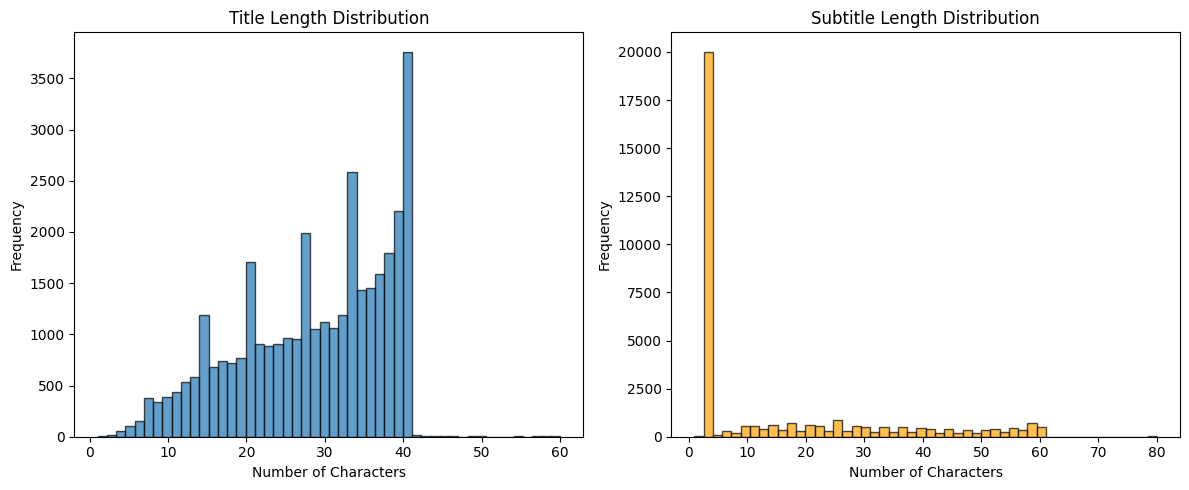

In [26]:

# Compute the length of titles and subtitles
df['title_length'] = df['title'].astype(str).apply(len)
df['subtitle_length'] = df['subtitle'].astype(str).apply(len)

# Create histograms for title and subtitle lengths
fig, ax = plt.subplots(1, 2, figsize=(12, 5))


ax[0].hist(df['title_length'], bins=50, edgecolor='black', alpha=0.7)
ax[0].set_title('Title Length Distribution')
ax[0].set_xlabel('Number of Characters')
ax[0].set_ylabel('Frequency')
ax[1].hist(df['subtitle_length'], bins=50, edgecolor='black', alpha=0.7, color='orange')
ax[1].set_title('Subtitle Length Distribution')
ax[1].set_xlabel('Number of Characters')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Analysis of Product Type Frequency Distribution

Count the occurrences of each productType and Plot histogram of product type frequencies

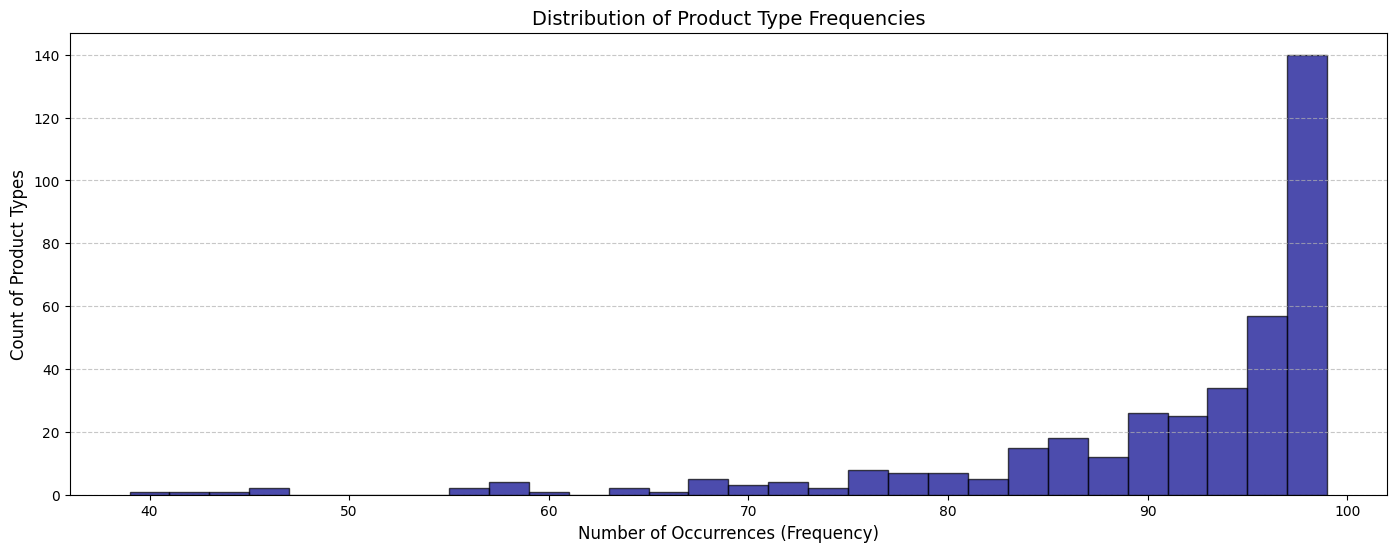

In [27]:
# Count the occurrences of each productType
product_type_counts = df['productType'].value_counts()

# Plot histogram of product type frequencies
plt.figure(figsize=(17, 6))
plt.hist(product_type_counts, bins=30, color="darkblue", edgecolor='black', alpha=0.7)
plt.title('Distribution of Product Type Frequencies', fontsize=14)
plt.xlabel('Number of Occurrences (Frequency)', fontsize=12)
plt.ylabel('Count of Product Types', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Detect the Language of Title, Subtitle, and ProductType

In [28]:
def detect_language(text):
    try:
        return detect(text) if isinstance(text, str) and text.strip() != "" else "unknown"
    except:
        return "unknown"  # Handle detection errors

In [29]:
# Detect language for each column
df['title_language'] = df['title'].apply(detect_language)
df['subtitle_language'] = df['subtitle'].apply(detect_language)
df['productType_language'] = df['productType'].apply(detect_language)

In [42]:
df.loc[df['productType_language'] == 'ro', 'productType_language'] = 'en'

In [46]:
# Count occurrences of each detected language
title_lang_counts = df['title_language'].value_counts()
subtitle_lang_counts = df['subtitle_language'].value_counts()
productType_lang_counts = df['productType_language'].value_counts()


Select the top 5 languages for each feature to plot a pie chart

In [47]:
top_n = 5
top_title_langs = title_lang_counts.head(top_n)
top_subtitle_langs = subtitle_lang_counts.head(top_n)
top_productType_langs = productType_lang_counts.head(top_n)


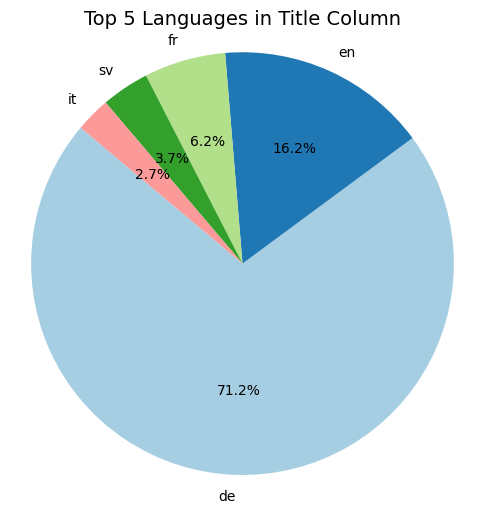

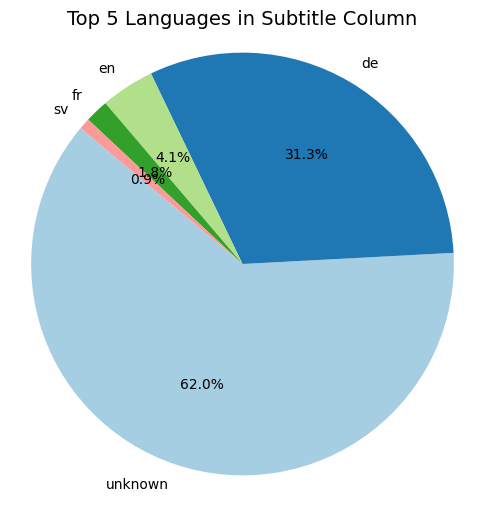

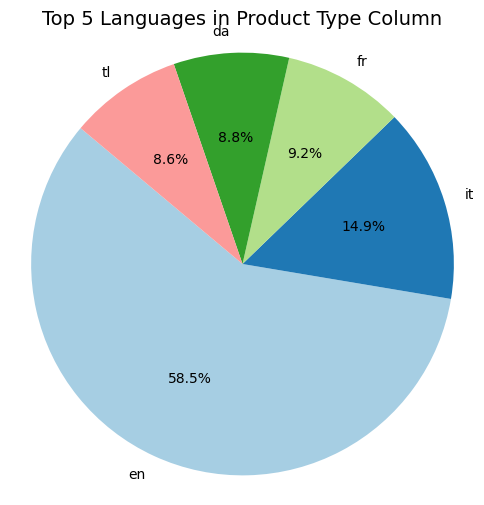

In [48]:
# Function to plot a pie chart
def plot_pie_chart(data, title):
    plt.figure(figsize=(6, 6))
    plt.pie(data, labels=data.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors, startangle=140)
    plt.title(title, fontsize=14)
    plt.axis('equal') 
    plt.show()


plot_pie_chart(top_title_langs, "Top 5 Languages in Title Column")
plot_pie_chart(top_subtitle_langs, "Top 5 Languages in Subtitle Column")
plot_pie_chart(top_productType_langs, "Top 5 Languages in Product Type Column")


## Text Processing

In [ ]:
# Load Spacy Lemmatizers for all supported languages
lemmatizers = {
    "en": English(),
    "de": German(),
    "it": Italian(),
    "fr": French(),
    "sv": Swedish(),
    "da": Danish(),
    "ro": Romanian(),
}

# Define stopwords for each language
stopwords_dict = {
    lang: set(stopwords.words(lang)) for lang in ["english", "german", "italian", "french", "swedish", "danish", "romanian"]
}

# Function to clean text safely
def clean_text(text, lang):
    if not isinstance(text, str) or text.strip() == "":
        return ""

    # Remove punctuation and numbers
    text = re.sub(r"[^a-zA-ZäöüßÄÖÜæøåÆØÅăâîșțĂÂÎȘȚ ]", "", text)
    words = text.split()

    # Remove stopwords if they exist for the language
    if lang in stopwords_dict:
        filtered_words = [word for word in words if word not in stopwords_dict[lang]]
        if len(filtered_words) > 0:  # Keep original if removing stopwords empties it
            words = filtered_words

    # Apply lemmatization if the language is supported
    if lang in lemmatizers:
        lemmatized = [token.lemma_ for token in lemmatizers[lang](" ".join(words))]
    else:
        lemmatized = words  # Keep original if language not supported

    clean_result = " ".join(lemmatized).strip()
    return clean_result if clean_result else text  


df["subtitle"] = df["subtitle"].fillna("")

# Convert text to lowercase
df["title"] = df["title"].str.lower()
df["subtitle"] = df["subtitle"].str.lower()

# Remove redundant subtitles
duplicates = df[df["title"] == df["subtitle"]]
if not duplicates.empty:
    print("Example where title == subtitle (removing subtitle):")
    print(duplicates[["title", "subtitle"]].head())

df.loc[df["title"] == df["subtitle"], "subtitle"] = ""


df["title_clean"] = df.apply(lambda row: clean_text(row["title"], row["title_language"]), axis=1)
df["subtitle_clean"] = df.apply(lambda row: clean_text(row["subtitle"], row["subtitle_language"]), axis=1)


# Replace underscores with spaces 
df["productType"] = df["productType"].str.replace("_", " ")

Example where title == subtitle (removing subtitle):
                                         title  \
8              - edition seeigel - gackitas ei   
7306  1 1261902 - rüschenhemd schwarz gr. 50/m   
2069                     1 alter holzschlitten   
9211           1 paar schöne manschettenknöpfe   
8805      10 franken note 1965 wenig gebraucht   

                                      subtitle  
8              - edition seeigel - gackitas ei  
7306  1 1261902 - rüschenhemd schwarz gr. 50/m  
2069                     1 alter holzschlitten  
9211           1 paar schöne manschettenknöpfe  
8805      10 franken note 1965 wenig gebraucht  


In [ ]:
df.to_csv('/home/ubuntu/product_classifier/di-interview-product-classifier/products/cleaned_data.csv',index=False)

In [ ]:
df.columns

Index(['articleId', 'title', 'subtitle', 'productType', 'title_length',
       'subtitle_length', 'title_language', 'subtitle_language',
       'productType_language', 'title_clean', 'subtitle_clean', 'text'],
      dtype='object')